In [1]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import ast
import nltk
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

### Reading in Data ###

In [2]:
df = pd.read_csv('final_df.csv')

df['preprocessed_receipt'] = df['preprocessed_receipt'].apply(ast.literal_eval)
df['bio_tags'] = df['bio_tags'].apply(ast.literal_eval)
df['tokenized_receipt'] = df['tokenized_receipt'].apply(ast.literal_eval)
df.head()

15662


,venue_id,receipt_key,receipt_file,tokenized_receipt,preprocessed_receipt,parsed_receipt,bio_tags
0,5531,5531/01/0000000036812256/202003181643-u1584546...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
1,5531,5531/01/0000000036812256/202005150714-u1589519...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
2,5531,5531/01/0000000036812256/202005151410-u1589544...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
3,5531,5531/01/0000000036812256/202005152249-u1589575...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]
4,5531,5531/01/0000000036812256/202005180927-u1589786...,*_*_*_*_*_*_*_*_*_*_*_*_*_*\nThis receipt is p...,"[[*_*_*_*_*_*_*_*_*_*_*_*_*_*], [This, receipt...",[[*_*_*_*_*_*_*_*_*_*_*_*_*_*]],NaN,[[O]]


In [35]:
df = df.dropna()
data = df
data.reset_index(drop=True, inplace=True)
df.head()

,venue_id,receipt_key,receipt_file,tokenized_receipt,preprocessed_receipt,parsed_receipt,bio_tags
0,5531,5531/01/0000000036812256/202007161954-u1594922...,**start** \n--...,"[[**start**], [--paid--], [Table:, 2], [------...","[[1, x, Thee, =>, 2,20], [3, x, Jus, d'Orange,...",Thee x 1 order 220 Notes: _Jus d'Orange x 3 or...,"[[B-QTY, O, B-UNIT, O, B-PRICE], [B-QTY, O, B-..."
1,5531,5531/01/0000000036812256/202007162054-u1594925...,**start** \n--...,"[[**start**], [--paid--], [Table:, 7], [------...","[[2, x, Gregorius, =>, 15,90], [2, x, Grimberg...",Gregorius x 2 order 1590 Notes: _Grimbergen Bl...,"[[B-QTY, O, B-UNIT, O, B-PRICE], [B-QTY, O, B-..."
2,5531,5531/01/0000000036812256/202007162154-u1594929...,**start** \n--...,"[[**start**], [--paid--], [Table:, 2], [------...","[[1, x, Lipton, Ice-Tea, =>, 2,70], [2, x, Sou...",Lipton Ice-Tea x 1 order 270 Notes: _Sourcy Ro...,"[[B-QTY, O, B-UNIT, I-UNIT, O, B-PRICE], [B-QT..."
3,5531,5531/01/0000000036812256/202007162254-u1594932...,**start** \n--...,"[[**start**], [--paid--], [Table:, 7], [------...","[[6, x, Pico, de, Aneto, =>, 25,50], [1, x, Ru...",Pico de Aneto x 6 order 2550 Notes: _Rundvlees...,"[[B-QTY, O, B-UNIT, I-UNIT, I-UNIT, O, B-PRICE..."
4,5531,5531/01/0000000036812256/202007162254-u1594932...,**start** \n--...,"[[**start**], [--paid--], [Table:, 2], [------...","[[1, x, Pinot, Grigio, Torre, Dei, V, =>, 4,50...",Pinot Grigio Torre Dei V x 1 order 450 Notes: ...,"[[B-QTY, O, B-UNIT, I-UNIT, I-UNIT, I-UNIT, I-..."


### Extract labels for noise tokens ###

In [36]:
def get_new_bio_tags(tokenized_receipt, preprocessed_receipt, bio_tags):
    new_tags = []
    preprocessed_receipt_tuples = [tuple(line) for line in preprocessed_receipt]
    
    tag_dict = dict(zip(preprocessed_receipt_tuples, bio_tags))
    for line in tokenized_receipt:
        line_tuple = tuple(line)
        if line not in preprocessed_receipt:
            line_length = len(line)
            o_line = ['O'] * line_length
            new_tags.append(o_line)
        else:
            new_tags.append(tag_dict[line_tuple])
            
    return new_tags

[['O'], ['O'], ['O', 'O'], ['O'], ['B-QTY', 'O', 'B-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['B-QTY', 'O', 'B-UNIT', 'I-UNIT', 'O', 'B-PRICE'], ['O'], ['O'], ['O'], ['O', 'O', 'O'], ['O'], ['O', 'O', 'O'], ['O', 'O', 'O'], ['O'], ['O', 'O'], ['O'], ['O']]
[['**start**'], ['--paid--'], ['Table:', '2'], ['------------------------------------------'], ['1', 'x', 'Thee', '=>', '2,20'], ['3', 'x', 'Jus', "d'Orange",

In [37]:
df['bio_tags'] = df.apply(lambda row: get_new_bio_tags(row['tokenized_receipt'], row['preprocessed_receipt'], row['bio_tags']), axis=1)
df.loc[1234,'tokenized_receipt']

[['**start**'],
 ['--paid--'],
 ['Table:', '1'],
 ['------------------------------------------'],
 ['2', 'x', 'Karmeliet', '=>', '11,00'],
 ['------------------------------------------'],
 ['11,00'],
 ['------------------------------------------'],
 ['Contant', '=>', '11,00'],
 ['------------------------------------------'],
 ['21%', '=>', '1,91'],
 ['------------------------------------------'],
 ['01.08.2020', '16:27'],
 ['**end**'],
 ['V\x01']]

In [38]:
bio_tags = [tag for receipt in df['bio_tags'] for line in receipt for tag in line]
tags = list(set(bio_tags))
print(tags)

['B-QTY', 'B-UNIT', 'B-NOTE', 'B-PRICE', 'O', 'I-NOTE', 'I-UNIT']


### Feature Extraction ###

In [39]:
def word_features(sentence, i):
    word = sentence[i][0]
    features = {
        'word': word,
        'is_first': i == 0,
        'is_last': i == len(sentence) - 1, 
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,   
        'is_all_lower': word.lower() == word,     
        'prefix-1': word[0],   
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'prev_word': '' if i == 0 else sentence[i-1][0],  
        'next_word': '' if i == len(sentence)-1 else sentence[i+1][0],
        'is_all_hyphens': all(char == '-' for char in word), 
        'is_all_stars': all(char == '*' for char in word),
        'is_numeric': word.isdigit(), 
        'has_equal' : '=' in word,
        'length' : len(word)
    }
    return features

train_df = df[df['venue_id'] != 5531]
test_df = df[df['venue_id'] == 5531]

#Change 'tokenized_receipt' column to 'preprocessed_receipt' in train_df for training with noise removed

train_corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(train_df['tokenized_receipt'], train_df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]
test_corpus = [list(zip(line, line_tags)) for receipt, receipt_tags in zip(test_df['tokenized_receipt'], test_df['bio_tags']) for line, line_tags in zip(receipt, receipt_tags) ]

for i in train_corpus[:5]:
    print(i)

[('_____________________________________________', 'O')]
[('15-07-2020', 'O')]
[('13:27', 'O')]
[('63', 'O')]
[('Tafel', 'O'), ('11', 'O'), ('en', 'O'), ('10', 'O'), ('A', 'O')]


In [40]:
X_train = []
y_train = []
for sentence in train_corpus:
    X_sentence = []
    y_sentence = []
    for i in range(len(sentence)):
        X_sentence.append(word_features(sentence, i))
        y_sentence.append(sentence[i][1])
    X_train.append(X_sentence)
    y_train.append(y_sentence)

X_test = []
y_test = []
for sentence in test_corpus:
    X_sentence = []
    y_sentence = []
    for i in range(len(sentence)):
        X_sentence.append(word_features(sentence, i))
        y_sentence.append(sentence[i][1])
    X_test.append(X_sentence)
    y_test.append(y_sentence)

### Model Training ###

In [41]:

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
 
y_pred = crf.predict(X_test)
 
print(metrics.flat_accuracy_score(y_test, y_pred))

0.9620873609337953


In [42]:
from sklearn.metrics import classification_report

y_test_flat = [label for sublist in y_test for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

labels = list(crf.classes_)
print(classification_report(y_test_flat, y_pred_flat, digits=3))


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      B-NOTE      0.000     0.000     0.000         0
     B-PRICE      0.816     0.893     0.853      7666
       B-QTY      0.999     0.994     0.997      7782
      B-UNIT      0.979     0.997     0.988      7654
      I-NOTE      0.000     0.000     0.000         0
      I-UNIT      0.995     0.979     0.987     10324
           O      0.984     0.959     0.971     54302

    accuracy                          0.962     87728
   macro avg      0.682     0.689     0.685     87728
weighted avg      0.971     0.962     0.966     87728



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
from sklearn.metrics import classification_report

y_test_flat = [label for sublist in y_test for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]


labels = list(crf.classes_)
print(classification_report(y_test_flat, y_pred_flat, digits=3))


              precision    recall  f1-score   support

     B-PRICE      0.995     0.999     0.997      7666
       B-QTY      0.999     0.999     0.999      7782
      B-UNIT      0.979     0.997     0.988      7654
      I-UNIT      0.997     0.980     0.988     10324
           O      1.000     1.000     1.000     15584

    accuracy                          0.995     49010
   macro avg      0.994     0.995     0.995     49010
weighted avg      0.995     0.995     0.995     49010



### Result Visualization ###

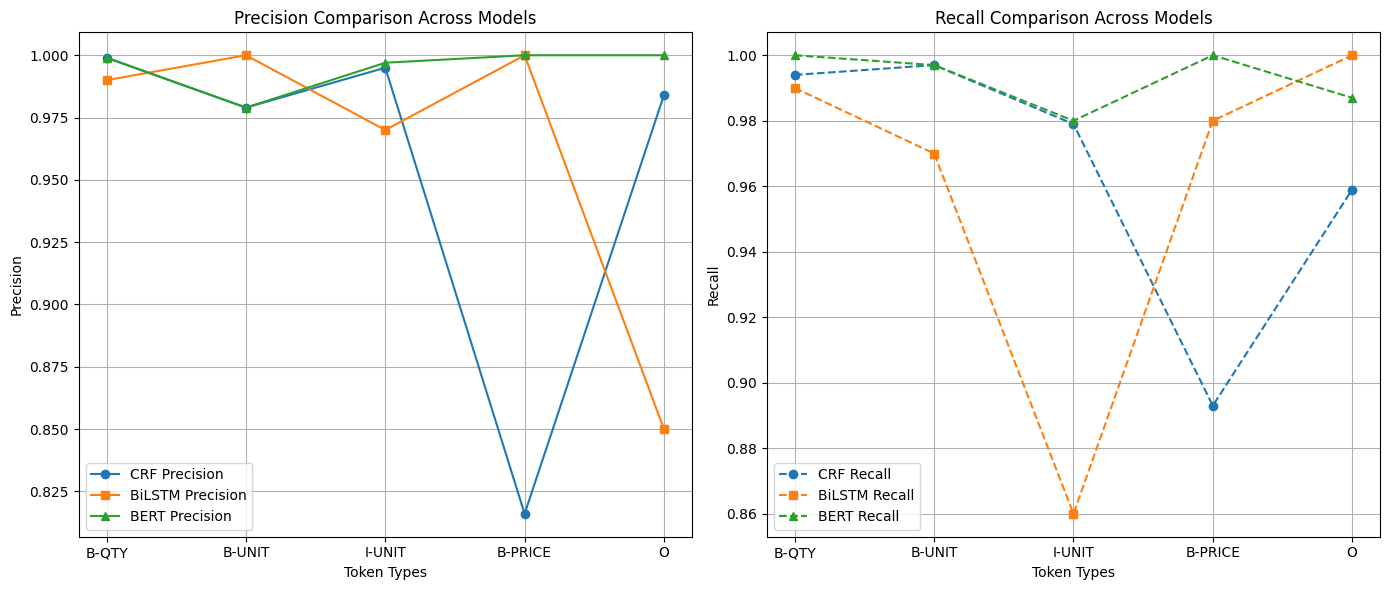

In [44]:
import matplotlib.pyplot as plt
import numpy as np

tokens = ['B-QTY', 'B-UNIT', 'I-UNIT', 'B-PRICE', 'O']

crf_precision = [0.999, 0.979, 0.995, 0.816, 0.984]
crf_recall = [0.994, 0.997, 0.979, 0.893, 0.959]

bilstm_precision = [0.99, 1.00, 0.97, 1.00, 0.85]
bilstm_recall = [0.99, 0.97, 0.86, 0.98, 1.00]

bert_precision = [0.999, 0.979, 0.997, 1.000, 1.000]
bert_recall = [1.000, 0.997, 0.980, 1.000, 0.987]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(tokens, crf_precision, marker='o', linestyle='-', label='CRF Precision')
ax1.plot(tokens, bilstm_precision, marker='s', linestyle='-', label='BiLSTM Precision')
ax1.plot(tokens, bert_precision, marker='^', linestyle='-', label='BERT Precision')
ax1.set_title('Precision Comparison Across Models')
ax1.set_xlabel('Token Types')
ax1.set_ylabel('Precision')
ax1.legend()
ax1.grid(True)

ax2.plot(tokens, crf_recall, marker='o', linestyle='--', label='CRF Recall')
ax2.plot(tokens, bilstm_recall, marker='s', linestyle='--', label='BiLSTM Recall')
ax2.plot(tokens, bert_recall, marker='^', linestyle='--', label='BERT Recall')
ax2.set_title('Recall Comparison Across Models')
ax2.set_xlabel('Token Types')
ax2.set_ylabel('Recall')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


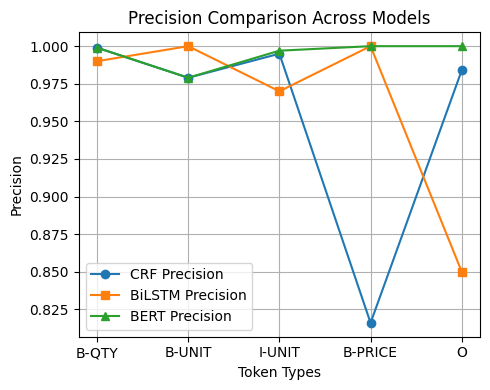

In [49]:
import matplotlib.pyplot as plt
import numpy as np

tokens = ['B-QTY', 'B-UNIT', 'I-UNIT', 'B-PRICE', 'O']
crf_precision = [0.999, 0.979, 0.995, 0.816, 0.984]
bilstm_precision = [0.99, 1.00, 0.97, 1.00, 0.85]
bert_precision = [0.999, 0.979, 0.997, 1.000, 1.000]

plt.figure(figsize=(5, 4))
plt.plot(tokens, crf_precision, marker='o', linestyle='-', label='CRF Precision')
plt.plot(tokens, bilstm_precision, marker='s', linestyle='-', label='BiLSTM Precision')
plt.plot(tokens, bert_precision, marker='^', linestyle='-', label='BERT Precision')
plt.title('Precision Comparison Across Models')
plt.xlabel('Token Types')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


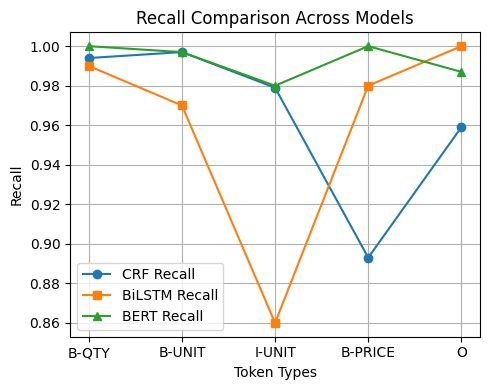

In [50]:
import matplotlib.pyplot as plt
import numpy as np

tokens = ['B-QTY', 'B-UNIT', 'I-UNIT', 'B-PRICE', 'O']
crf_recall = [0.994, 0.997, 0.979, 0.893, 0.959]
bilstm_recall = [0.99, 0.97, 0.86, 0.98, 1.00]
bert_recall = [1.000, 0.997, 0.980, 1.000, 0.987]

plt.figure(figsize=(5, 4))
plt.plot(tokens, crf_recall, marker='o', linestyle='-', label='CRF Recall')
plt.plot(tokens, bilstm_recall, marker='s', linestyle='-', label='BiLSTM Recall')
plt.plot(tokens, bert_recall, marker='^', linestyle='-', label='BERT Recall')
plt.title('Recall Comparison Across Models')
plt.xlabel('Token Types')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


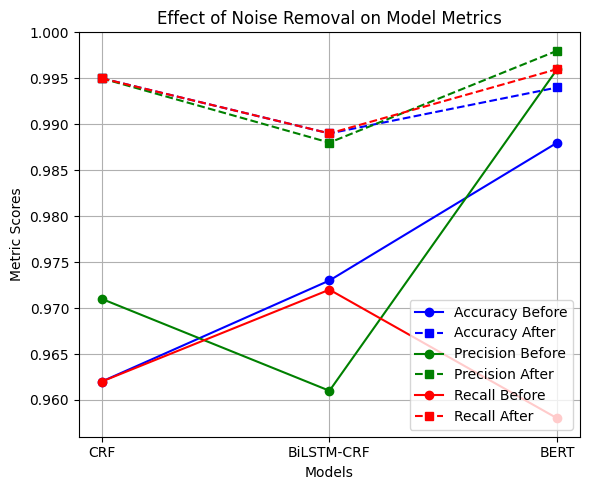

In [67]:
import matplotlib.pyplot as plt
import numpy as np

models = ['CRF', 'BiLSTM-CRF', 'BERT']
metrics = ['Accuracy', 'Precision', 'Recall']

before_noise_removal = np.array([
    [0.962, 0.971, 0.962],  # CRF
    [0.973, 0.961, 0.972],  # BiLSTM-CRF
    [0.988, 0.996, 0.958]   # BERT
])

after_noise_removal = np.array([
    [0.995, 0.995, 0.995],  # CRF
    [0.989, 0.988, 0.989],  # BiLSTM-CRF
    [0.994, 0.998, 0.996]   # BERT
])

fig, ax = plt.subplots(figsize=(6, 5))

colors = ['b', 'g', 'r']
before_marker = 'o'
after_marker = 's'

for i, metric in enumerate(metrics):
    ax.plot(models, before_noise_removal[:, i], marker=before_marker, linestyle='-', color=colors[i], label=f'{metric} Before')
    ax.plot(models, after_noise_removal[:, i], marker=after_marker, linestyle='--', color=colors[i], label=f'{metric} After')

ax.set_xlabel('Models')
ax.set_ylabel('Metric Scores')
ax.set_title('Effect of Noise Removal on Model Metrics')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


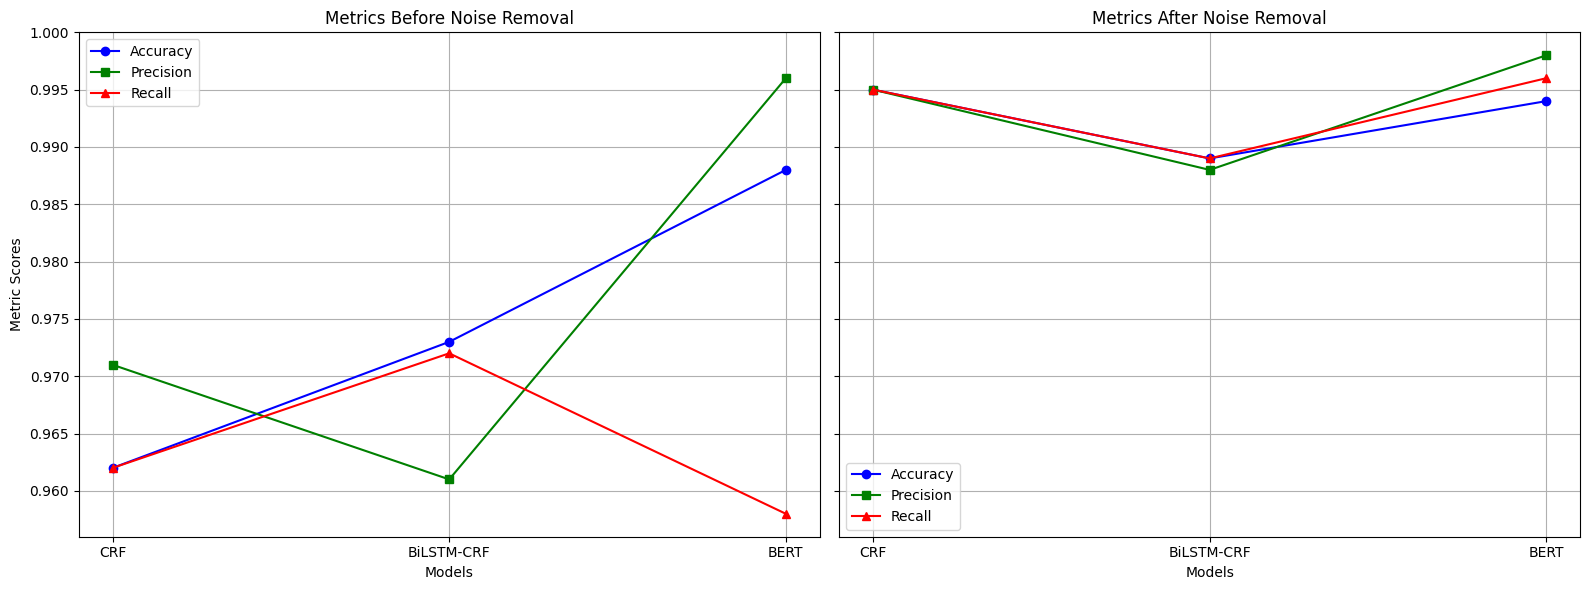

In [3]:
import matplotlib.pyplot as plt
import numpy as np

models = ['CRF', 'BiLSTM-CRF', 'BERT']
metrics = ['Accuracy', 'Precision', 'Recall']

before_noise_removal = np.array([
    [0.962, 0.971, 0.962],  # CRF
    [0.973, 0.961, 0.972],  # BiLSTM-CRF
    [0.988, 0.996, 0.958]   # BERT
])

after_noise_removal = np.array([
    [0.995, 0.995, 0.995],  # CRF
    [0.989, 0.988, 0.989],  # BiLSTM-CRF
    [0.994, 0.998, 0.996]   # BERT
])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

colors = ['b', 'g', 'r']
markers = ['o', 's', '^']

for i, metric in enumerate(metrics):
    ax1.plot(models, before_noise_removal[:, i], marker=markers[i], linestyle='-', color=colors[i], label=f'{metric}')

for i, metric in enumerate(metrics):
    ax2.plot(models, after_noise_removal[:, i], marker=markers[i], linestyle='-', color=colors[i], label=f'{metric}')

ax1.set_title('Metrics Before Noise Removal')
ax1.set_xlabel('Models')
ax1.set_ylabel('Metric Scores')
ax1.legend()
ax1.grid(True)

ax2.set_title('Metrics After Noise Removal')
ax2.set_xlabel('Models')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
